In [7]:
import requests
import json
import pandas as pd
import calendar

In [8]:
# MBTA Monthly Ridership
# Call api and create dataframe
url = 'https://services1.arcgis.com/ceiitspzDAHrdGO1/arcgis/rest/services/MBTA_Monthly_Ridership_By_Mode/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson'
ridership_response = requests.get(url).text
ridership_json = json.loads(ridership_response)
ridership_df = pd.json_normalize(ridership_json['features'])

# conver the date column from milliseconds to datetime
ridership_df['Date'] = pd.to_datetime(ridership_df['properties.service_date'], unit='ms')

In [9]:
# change the names of the columns
ridership_df.rename(columns={'properties.route_or_line':'Route/Line', 'properties.average_monthly_weekday_ridersh':'Avg Monthly Weekday Ridership',
                    'properties.average_monthly_ridership':'Avg Monthly Ridership'}, inplace=True)

In [10]:
# clean the dataframe values
# convert the datetime into two columns: month and year
ridership_df['Year'] = pd.DatetimeIndex(ridership_df['Date']).year
ridership_df['month_num'] = pd.DatetimeIndex(ridership_df['Date']).month
ridership_df['Month'] = ridership_df['month_num'].apply(lambda x: calendar.month_name[x])
ridership_df.drop(columns=['Date'])

# reorder columns
ridership_df = ridership_df[['Year', 'Month', 'Route/Line',	'Avg Monthly Weekday Ridership', 'Avg Monthly Ridership', 'month_num']]

# drop all data that is unrelated to rail ridership
ridership_df = ridership_df[ridership_df['Route/Line'].isin(['Green Line', 'Orange Line', 'Red Line', 'Blue Line'])]

In [11]:
import matplotlib.pyplot as plt
import numpy as np

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (12,) and arg 1 with shape (11,).

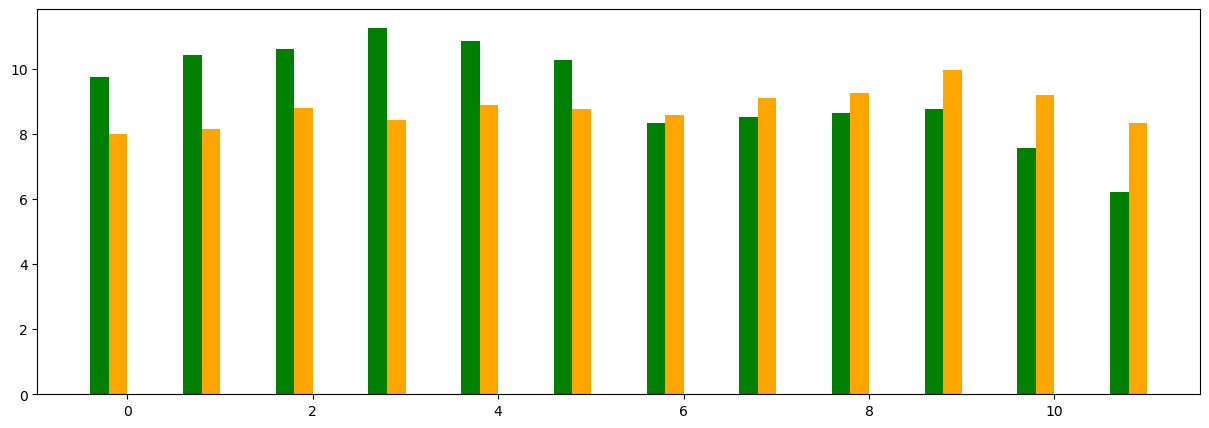

In [12]:
# select a specific year of data to use
ridership_df = ridership_df[ridership_df['Year'] == 2023].sort_values(by='month_num', ascending=True)

# create lists of average monthly ridership for each line to be plotted
y_data = {}
for line in ['Green Line', 'Orange Line', 'Red Line', 'Blue Line']:
    data = ridership_df[ridership_df['Route/Line'] == line]['Avg Monthly Ridership'].tolist()
    y_data[line] = [(x / 10000) for x in data]

# create the plot figure and set the size
plt.figure(figsize=(15, 5))

# plot the 4 different lines across each month
# x list is used to specify where each month will go and where the four bars will center around
x = np.arange(len(ridership_df['Month'])/4)
bar_width = .2
bar_loc = -1.5
for line in y_data:
    plt.bar(x + bar_width * bar_loc, y_data[line], width=bar_width, label=line, color=line.split()[0])
    bar_loc += 1

# set axis labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Avg Monthly Ridership (in 10,000s)')
plt.title('Avg Monthly Ridership by Month for Each MBTA Line in 2023')
plt.xticks(x, ridership_df['Month'].unique())
plt.legend(loc='upper right', bbox_to_anchor=(1.08, 1))
plt.show()